In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58fd4000 @  0x7f2edef712a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [2]:
!pip install gputil
import GPUtil
GPUtil.showUtilization()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Colab_Notebooks/day9")
os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Colab_Notebooks/day9'

In [4]:
!ls

day9_colab.ipynb


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [6]:
print('version :' , torch.__version__)
print('cuda :' , torch.cuda.is_available())
print('cudnn :' , torch.backends.cudnn.enabled)

version : 0.4.1
cuda : True
cudnn : True


In [0]:
EPOCH = 10
BATCH_SIZE = 200
LR = 0.001
DOWNLOAD_data = True

In [8]:
train_data = torchvision.datasets.CIFAR10(
    root = './data',
    train = True,
    transform=torchvision.transforms.ToTensor(), #改成torch可讀
    download=DOWNLOAD_data,
)


50000
50000


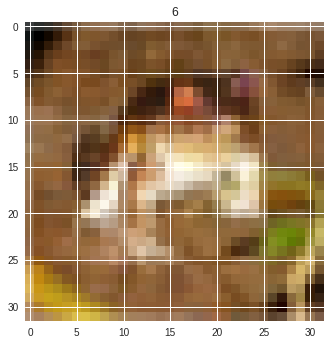

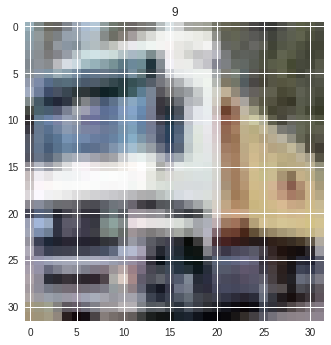

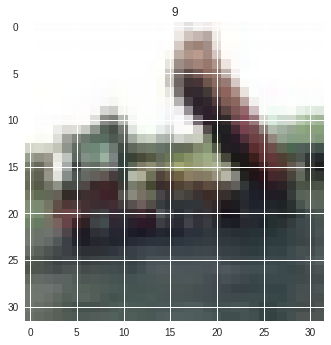

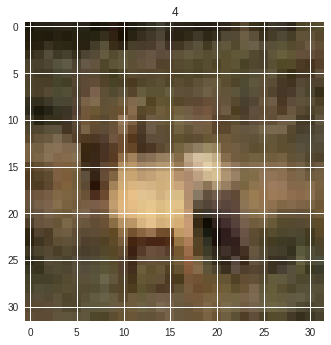

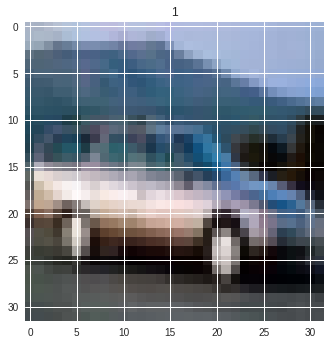

In [9]:
print(len(train_data.train_data))
print(len(train_data.train_labels))
for i in range(5):    
    img = np.asarray(train_data.train_data[i])
    plt.imshow(img, cmap='gray')
    plt.title('%i' % train_data.train_labels[i])
    plt.show()

In [0]:
test_data = torchvision.datasets.CIFAR10(root='./data/',
                              train=False,
                              transform=torchvision.transforms.ToTensor())

10000
3000


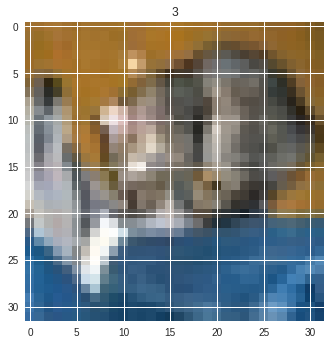

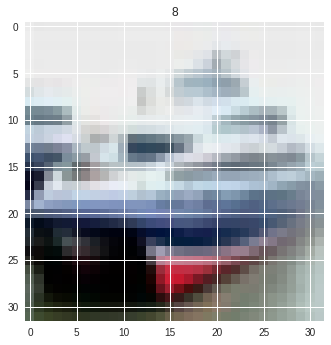

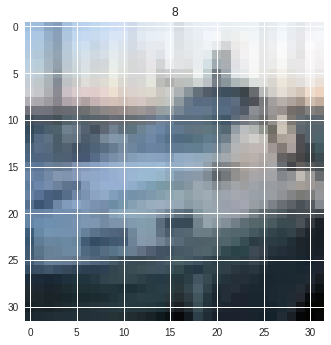

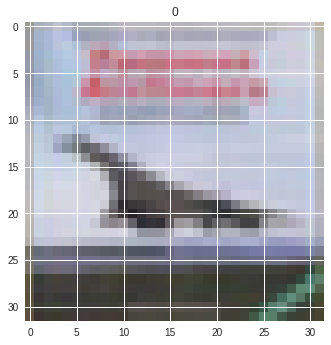

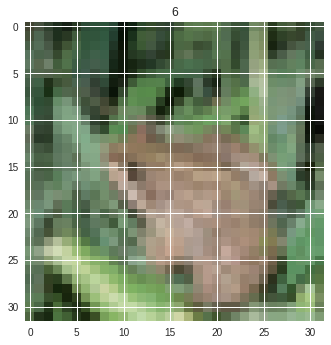

In [11]:
print(len(test_data.test_data))
test_data.test_data = test_data.test_data[:3000]
test_data.test_labels = test_data.test_labels[:3000]
print(len(test_data.test_data))
for i in range(5):    
    img = np.asarray(test_data.test_data[i])
    plt.imshow(img, cmap='gray')
    plt.title('%i' % test_data.test_labels[i])
    plt.show()

In [12]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)
print(train_loader)
print(len(train_loader))
print(test_loader)
print(len(test_loader))

250
15


In [13]:
#test_data = torchvision.datasets.CIFAR10(root='./data/', train=False)
#print(type(test_data.test_data))

############
#i dont's know way this type was 'numpy.ndarray', so i convert it myself
#test_data.test_data = torch.unsqueeze(torch.from_numpy(test_data.test_data), dim=3)
print(type(test_data.test_data))
#print(len(test_data.test_data))
############


<class 'numpy.ndarray'>


In [0]:
class InceptionA(nn.Module):
    def __init__(self,in_channels):
        super(InceptionA, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (3, _, _)
            nn.AvgPool2d(3,1,1),                # output shape (3, _, _)
            nn.Conv2d(in_channels,16,1),    # output shape (24, _, _)<<
        )
        self.conv2 = nn.Sequential(         # input shape (3, _, _)
            nn.MaxPool2d(3,1,1),                # output shape (3, _, _)
            nn.Conv2d(in_channels,16,1),    # output shape (16, _, _)<<
        )
        
        self.conv3 = nn.Sequential(         # input shape (3, _, _)
            nn.Conv2d(in_channels,16,1),    # output shape (16, _, _)
            nn.Conv2d(16,16,5,1,2),          # output shape (24, _, _)<<
        )
        
        self.conv4 = nn.Sequential(         # input shape (3, _, _)
            nn.Conv2d(in_channels,8,1),    # output shape (16, _, _)
            #nn.Conv2d(16,24,3,1,1),         # output shape (24, _, _)
            nn.Conv2d(8,16,3,1,1),         # output shape (24, _, _)<<
        )
        
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        
        outputs = [x2,x3,x4,x1]
        #outputs = [x3,x4,x1]#72
        
        return torch.cat(outputs,1)         # output shape (24*3+16, 32, 32)<<
                                            # output shape (88, 32, 32)<<
######################################################################
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (3, 32, 32)
            nn.Conv2d(3,20,5,1,2),          # output shape (20, 32, 32)
            InceptionA(in_channels=20),     # output shape (88, 32, 32)
            nn.MaxPool2d(2),                # output shape (88, 16, 16)
        )
        self.conv2 = nn.Sequential(         # input shape (88, 16, 16)
            nn.Conv2d(64,40,5,1,2),         # output shape (40, 16, 16)
            InceptionA(in_channels=40),     # output shape (88, 16, 16)
            nn.MaxPool2d(2),                # output shape (88, 8, 8)
        )
        
        self.out1 = nn.Linear(64*8*8, 512)   # fully connected layer
        self.out2 = nn.Linear(512, 128)
        self.out3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        #x = x.view(-1, 32 * 8 * 8)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.out1(x)
        x = self.out2(x)
        x = self.out3(x)
        #output = nn.log_softmax(x, dim=1)
        return x    # return x for visualization

In [15]:
cnn = CNN()
cnn.cuda()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): InceptionA(
      (conv1): Sequential(
        (0): AvgPool2d(kernel_size=3, stride=1, padding=1)
        (1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv2): Sequential(
        (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv3): Sequential(
        (0): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
      (conv4): Sequential(
        (0): Conv2d(20, 8, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 40, kernel_size=(5, 5), stride=(1, 1), paddin

In [0]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)   # optimize all cnn parameters
#optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
#loss_func = nn.NLLLoss()
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [0]:
def train(epoch):
    for step, (x, y) in enumerate(train_loader):
        data = Variable(x).cuda()   # batch x
        target = Variable(y).cuda()   # batch y

        output = cnn(data)               # cnn output
        loss = loss_func(output, target)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
           step * len(data), len(train_loader.dataset),100. * step / len(train_loader), loss.data.item()))
    print("Finish")
    GPUtil.showUtilization()
    
Epoch = np.arange(EPOCH-1)
Loss = np.arange(0)
Accuracy = np.arange(0)

#Loss = np.append(Loss,0.343534543534)
#print(Loss)


def test():
    cnn.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data).cuda(), Variable(target).cuda()
        output = cnn(data)
        # sum up batch loss
        los = loss_func(output, target)
        #print(los)
        test_loss += los
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    #print(test_loss)
    test_loss /= len(test_loader)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    #print(float(test_loss))
    global Loss
    global Accuracy
    Loss = np.append(Loss,float(test_loss))
    #print(Loss)
    Accuracy = np.append(Accuracy,float(100. * correct / len(test_loader.dataset)))
    
    GPUtil.showUtilization()

In [18]:
for epoch in range(1,EPOCH):
    train(epoch)
    #if epoch%2==0:
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.305712
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.756799
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.688673
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.451260
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.356609
Finish
| ID | GPU | MEM |
------------------
|  0 | 97% | 10% |

Test set: Average loss: 1.3633, Accuracy: 1550/3000 (51%)

| ID | GPU | MEM |
------------------
|  0 | 47% | 37% |
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.425444
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.279984
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.260728
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.103851
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.101950
Finish
| ID | GPU | MEM |
------------------
|  0 | 97% | 37% |

Test set: Average loss: 1.1533, Accuracy: 1793/3000 (59%)

| ID | GPU | MEM |
------------------
|  0 | 47% | 37% |
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.126705
Train Epoch: 3 [10000/50000 (20%)]	Loss: 0.998104
Train Epoch: 3 [20000/50000 (40%)]	Loss: 1.152045
Tra

In [19]:
torch.save(cnn, 'net.pkl')

print(Epoch)
print(Loss)
print(Accuracy)

[0 1 2 3 4 5 6 7 8]
[1.3632704  1.15326655 1.00541556 0.95669085 0.95221901 0.950203
 0.90759546 0.93983215 0.91590315]
[51. 59. 65. 67. 67. 67. 69. 68. 69.]


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type InceptionA. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


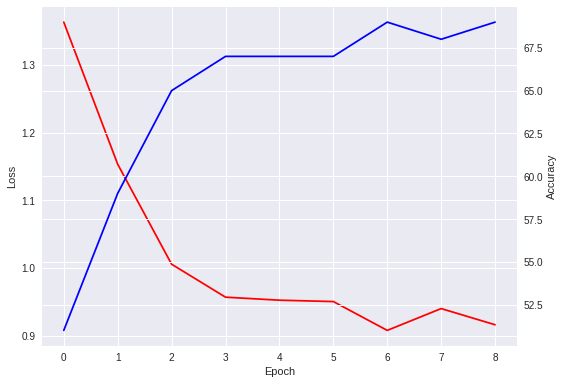

In [20]:
#plot

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(Epoch, Loss, color='red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(Epoch, Accuracy,color='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('result.png')
plt.show()